In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_dir = '/kaggle/input/plantvillage-dataset/color'
keyword=["Potato" , "Strawberry"]
class_folders = os.listdir(data_dir)
image_paths = []
labels = []

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
            class_path = os.path.join(data_dir, class_folder)
            image_files = os.listdir(class_path)
            print(class_path)
        
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)
            

df = pd.DataFrame({'image_path': image_paths, 'label': labels})


/kaggle/input/plantvillage-dataset/color/Potato___healthy
/kaggle/input/plantvillage-dataset/color/Strawberry___Leaf_scorch
/kaggle/input/plantvillage-dataset/color/Potato___Late_blight
/kaggle/input/plantvillage-dataset/color/Strawberry___healthy
/kaggle/input/plantvillage-dataset/color/Potato___Early_blight


In [3]:
df

,image_path,label
0,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___healthy
1,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___healthy
2,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___healthy
3,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___healthy
4,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___healthy
...,...,...
3712,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___Early_blight
3713,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___Early_blight
3714,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___Early_blight
3715,/kaggle/input/plantvillage-dataset/color/Potat...,Potato___Early_blight


In [4]:
print("The classes:\n", np.unique(df['label']))

The classes:
 ['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Strawberry___Leaf_scorch' 'Strawberry___healthy']


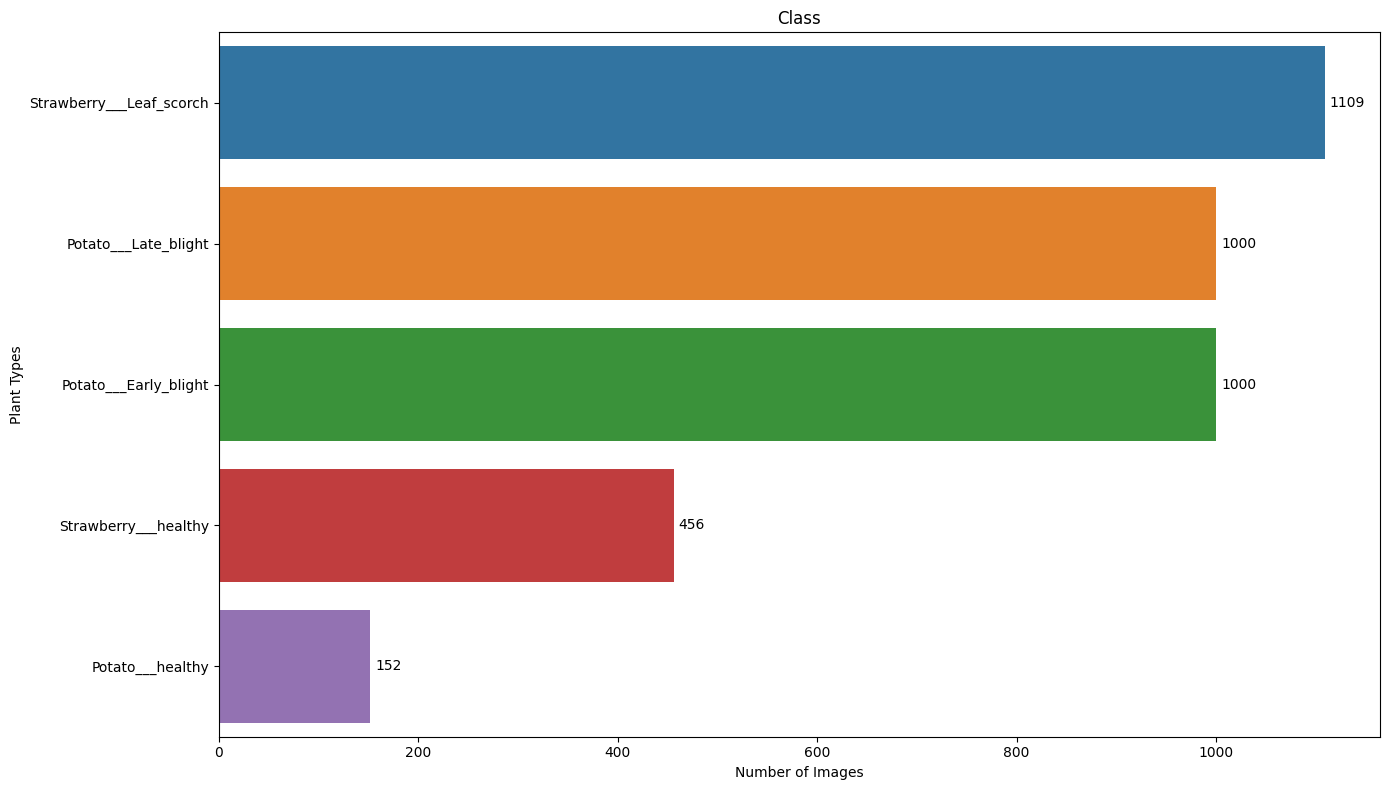

In [5]:
class_counts = df['label'].value_counts()

plt.figure(figsize=(14, 8))
x = seaborn.barplot(x=class_counts.values, y=class_counts.index, orient='h')
plt.title('Class')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()

for i, v in enumerate(class_counts.values):
    x.text(v + 5, i, str(v), color='black', va='center')

plt.show()

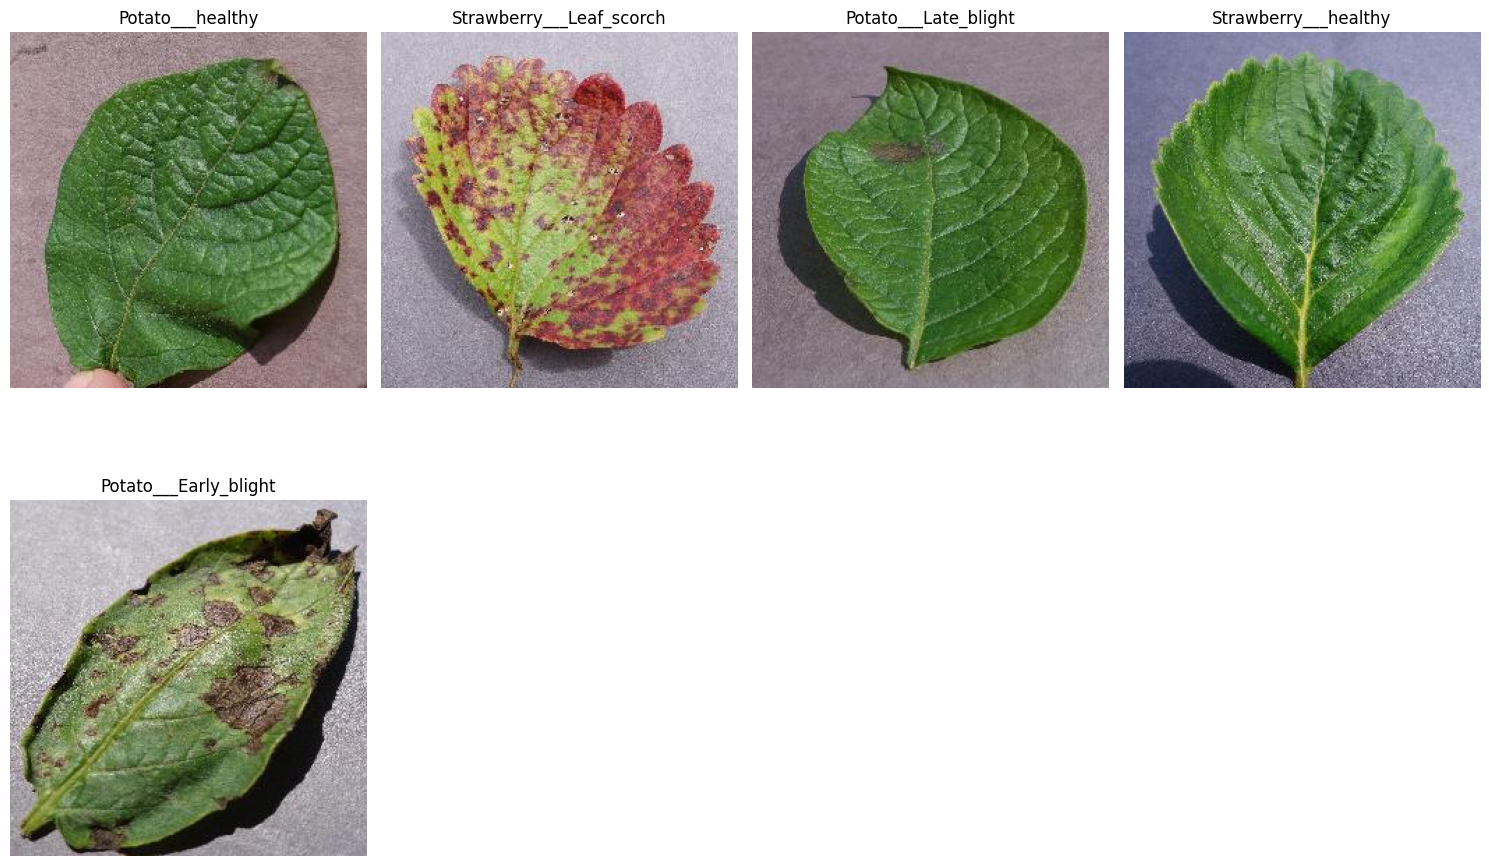

In [6]:
num_classes = len(df['label'].unique())

num_images_per_row = 4
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(15, 5 * num_rows))

for i, plant_class in enumerate(df['label'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    path = os.path.join(data_dir, df[df['label'] == plant_class]['image_path'].iloc[0])

    if os.path.exists(path):
        sample_image = cv2.imread(path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(plant_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {path}")
    else:
        print(f"Error: Image path does not exist: {path}")

plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [8]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224)):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [9]:
train_generator, validation_generator, test_generator = load_images_for_cnn(train_df, val_df, test_df, batch_size=64, target_size=(256, 256))

Found 2973 validated image filenames belonging to 5 classes.
Found 372 validated image filenames belonging to 5 classes.
Found 372 validated image filenames belonging to 5 classes.


In [10]:
# DenseNet
base_model = DenseNet121(weights='imagenet', include_top = False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

learning_rate = 0.0001

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [11]:
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/20
47/47 [==============================] - 81s 1s/step - loss: 0.9348 - accuracy: 0.6559 - val_loss: 0.6305 - val_accuracy: 0.9220
Epoch 2/20
47/47 [==============================] - 58s 1s/step - loss: 0.2781 - accuracy: 0.9233 - val_loss: 0.3694 - val_accuracy: 0.9570
Epoch 3/20
47/47 [==============================] - 58s 1s/step - loss: 0.1816 - accuracy: 0.9539 - val_loss: 0.2464 - val_accuracy: 0.9597
Epoch 4/20
47/47 [==============================] - 58s 1s/step - loss: 0.1388 - accuracy: 0.9654 - val_loss: 0.1717 - val_accuracy: 0.9597
Epoch 5/20
47/47 [==============================] - 57s 1s/step - loss: 0.1099 - accuracy: 0.9744 - val_loss: 0.1297 - val_accuracy: 0.9651
Epoch 6/20
47/47 [==============================] - 58s 1s/step - loss: 0.0865 - accuracy: 0.9791 - val_loss: 0.1050 - val_accuracy: 0.9651
Epoch 7/20
47/47 [==============================] - 58s 1s/step - loss: 0.0772 - accuracy: 0.9815 - val_loss: 0.0838 - val_accuracy: 0.9785
Epoch 8/20
47/47 [==

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

6/6 [==============================] - 2s 414ms/step - loss: 0.0312 - accuracy: 0.9839
Test Loss: 0.03115449845790863, Test Accuracy: 0.9838709831237793


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =  [ 'Potato___Early_blight', 'Potato___Late_blight','Potato___healthy','Strawberry___Leaf_scorch','Strawberry___healthy']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

6/6 [==============================] - 3s 196ms/step
                          precision    recall  f1-score   support

   Potato___Early_blight       1.00      0.98      0.99        84
    Potato___Late_blight       0.95      1.00      0.98       102
        Potato___healthy       0.93      0.78      0.85        18
Strawberry___Leaf_scorch       1.00      1.00      1.00       124
    Strawberry___healthy       1.00      1.00      1.00        44

                accuracy                           0.98       372
               macro avg       0.98      0.95      0.96       372
            weighted avg       0.98      0.98      0.98       372



<Axes: >

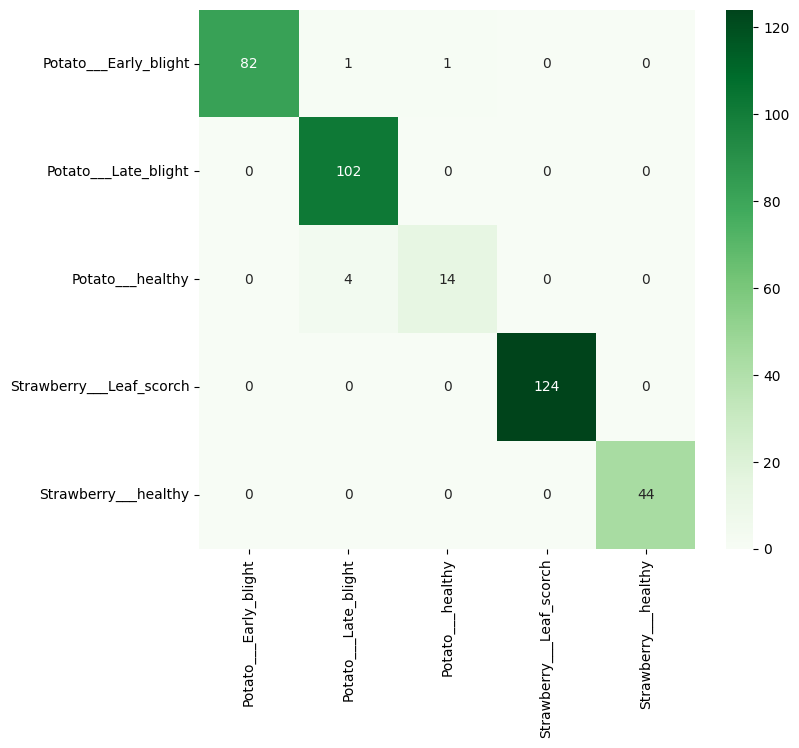

In [14]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in [ 'Potato___Early_blight', 'Potato___Late_blight','Potato___healthy','Strawberry___Leaf_scorch','Strawberry___healthy']],
                  columns = [i for i in  ['Potato___Early_blight', 'Potato___Late_blight','Potato___healthy', 'Strawberry___Leaf_scorch','Strawberry___healthy']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, cmap=plt.cm.Greens,annot=True, fmt='d')

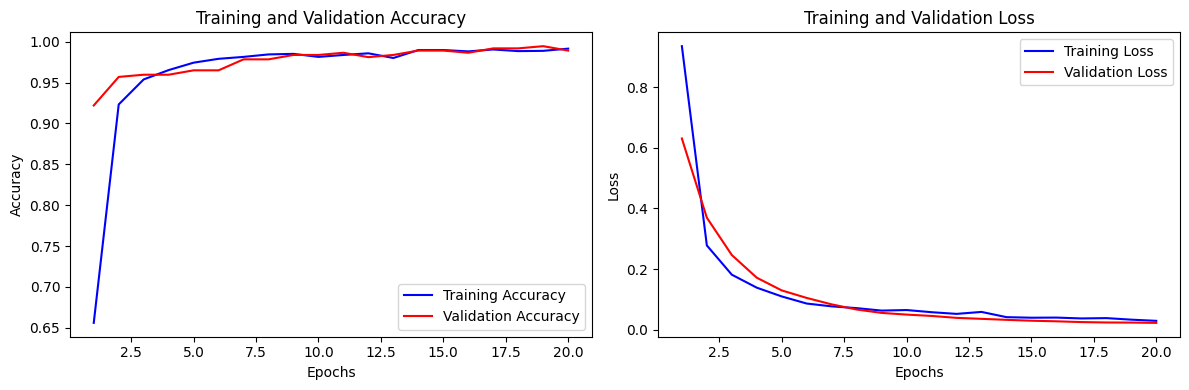

In [15]:

# Plot the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
model.save("model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
